## 2.3.4. 나이브 베이즈 분류기

### BernoulliNB 분류기 (2진분류)

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import mglearn
import scipy
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [20]:
X = np.array([[0,1,0,1],
              [1,0,1,1],
              [0,0,0,1],
              [1,0,1,0]])
y = np.array([0,1,0,1])

In [21]:
counts = {}
for label in np.unique(y):
    # iter every class
    # count 1 in every porp
    counts[label] = X[y==label].sum(axis=0)
print("특성 카운트:\n", counts)

특성 카운트:
 {0: array([0, 1, 0, 2]), 1: array([2, 0, 2, 1])}


## 2.3.5. 결정트리

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()
X = cancer.data
y = cancer.target
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y,random_state=42)

In [10]:
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)

print("training set accuracy : {:.3f}".format(tree.score(X_train, y_train)))
print("test set accuracy : {:.3f}".format(tree.score(X_test, y_test)))

training set accuracy : 1.000
test set accuracy : 0.937


max_depth 지정으로 테스트 세트의 성능개선

In [11]:
tree = DecisionTreeClassifier(random_state=0, max_depth=4)
tree.fit(X_train, y_train)

print("training set accuracy : {:.3f}".format(tree.score(X_train, y_train)))
print("test set accuracy : {:.3f}".format(tree.score(X_test, y_test)))

training set accuracy : 0.988
test set accuracy : 0.951


In [12]:
from sklearn.tree import export_graphviz
export_graphviz(tree, out_file="tree.dot", class_names=["malignancy", "benign"],
               feature_names=cancer.feature_names, impurity=False, filled=True)

In [18]:
import graphviz

with open("tree.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

#### 특성 중요도

결정 트리에서 각 특성이 얼마나 중요하게 작용하는지 여부

In [20]:
print("특성 중요도:\n", tree.feature_importances_)

특성 중요도:
 [0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]


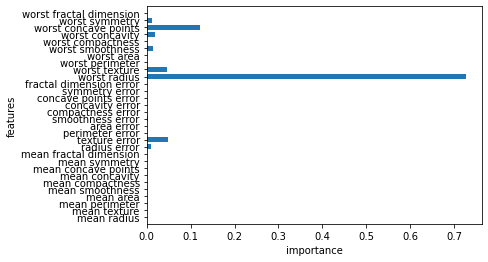

In [26]:
def plot_feature_importances_cancer(model):
    n_features = cancer.data.shape[1]
    plt.barh(np.arange(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel("importance")
    plt.ylabel("features")
    plt.ylim(-1, n_features)

plot_feature_importances_cancer(tree)

중요도가 낮다고 무조건 상관계수가 낮은 특성임을 의미하지는 않는다. 그보다는 트리가 어떤 특성을 선택했는지의 문제이다.

Feature importances: [0. 1.]


ExecutableNotFound: failed to execute 'dot', make sure the Graphviz executables are on your systems' PATH

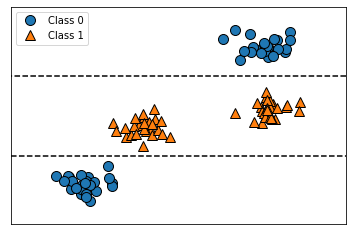

In [28]:
tree = mglearn.plots.plot_tree_not_monotone()
display(tree)

In [53]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
import os
# ~2000y : train data
# 2000y~ : test data

ram_prices = pd.read_csv(os.path.join(mglearn.datasets.DATA_PATH, "ram_price.csv"), index_col=0)
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# 가격 예측을 위해 날짜 특성만 이용
X_train = data_train.date.to_numpy()[:,np.newaxis]
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

#예측은 전체 기간 대상
X_all = ram_prices.date.to_numpy()[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

#예측한 값의 로그스케일 복원
price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

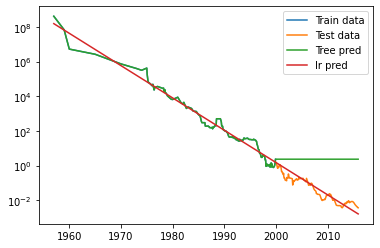

In [55]:
plt.semilogy(data_train.date, data_train.price, label="Train data")
plt.semilogy(data_test.date, data_test.price, label="Test data")
plt.semilogy(ram_prices.date, price_tree, label="Tree pred")
plt.semilogy(ram_prices.date, price_lr, label="lr pred")
plt.legend()

## 2.3.6. 결정트리 앙상블

### 랜덤 포레스트

In [61]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, noise=0.25, random_state=3)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=42)

forest = RandomForestClassifier(n_estimators=5, random_state=2)
forest.fit(X_train, y_train)

RandomForestClassifier(n_estimators=5, random_state=2)

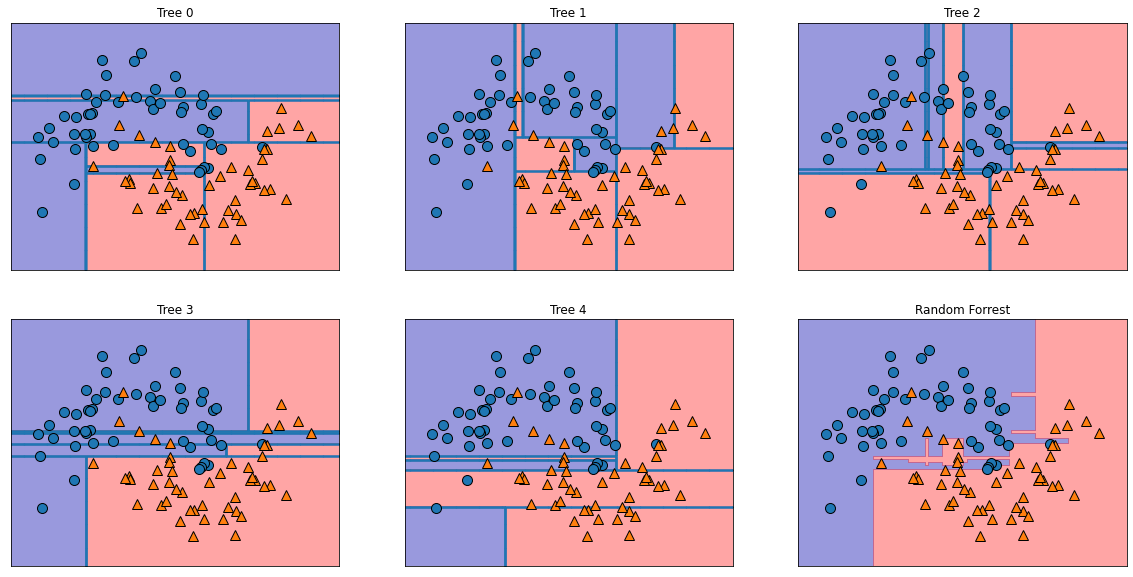

In [62]:
fig, axes = plt.subplots(2, 3, figsize=(20,10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), forest.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(X, y, tree, ax=ax)

mglearn.plots.plot_2d_separator(forest, X, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("Random Forrest")
mglearn.discrete_scatter(X[:,0], X[:,1], y)

In [77]:
X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)
forest = RandomForestClassifier(n_estimators=100, random_state=0)
forest.fit(X_train, y_train)

print("training set acc : ", forest.score(X_train, y_train))
print("test set acc : ", forest.score(X_test, y_test))


#mglearn.plots.plot_2d_separator(forest, X_train, fill=True, alpha=.4)

training set acc :  1.0
test set acc :  0.972027972027972


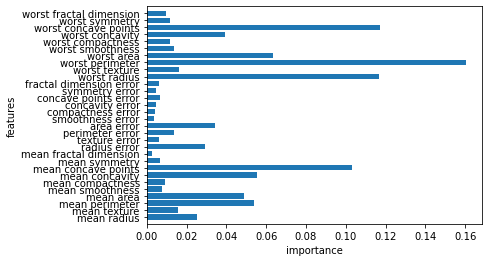

In [78]:
plot_feature_importances_cancer(forest)

### 그래디언트 부스팅 회귀 트리

In [80]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print("train set acc : {:.3f}".format(gbrt.score(X_train, y_train)))
print("test set acc : {:.3f}".format(gbrt.score(X_test, y_test)))

train set acc : 1.000
test set acc : 0.965


과대적합 방지를 위해 트리의 높이 또는 학습률을 조정

In [87]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0, max_depth=1)
gbrt.fit(X_train, y_train)

print("train set acc : {:.3f}".format(gbrt.score(X_train, y_train)))
print("test set acc : {:.3f}".format(gbrt.score(X_test, y_test)))

train set acc : 0.991
test set acc : 0.972


In [86]:
from sklearn.ensemble import GradientBoostingClassifier

X_train, X_test, y_train, y_test = train_test_split(cancer.data, cancer.target, random_state=0)

gbrt = GradientBoostingClassifier(random_state=0, learning_rate=0.01)
gbrt.fit(X_train, y_train)

print("train set acc : {:.3f}".format(gbrt.score(X_train, y_train)))
print("test set acc : {:.3f}".format(gbrt.score(X_test, y_test)))

train set acc : 0.988
test set acc : 0.965


각 특성의 중요도 분석

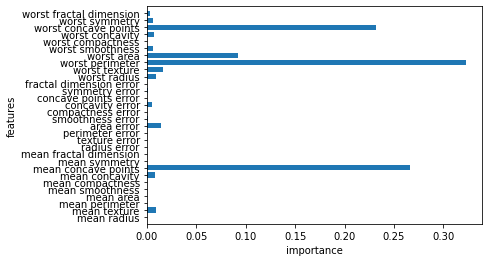

In [88]:
plot_feature_importances_cancer(gbrt)

랜덤포레스트와 다르게 완전히 무시하는 특성이 다수 존재함

## 2.3.7. 배깅, 엑스트라트리, 에이다부스트

### 배깅

In [94]:
from preamble import *
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.datasets import load_breast_cancer

Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=3)
Xm_train, Xm_test, ym_train, ym_test = train_test_split(Xm, ym, stratify=ym, random_state=42)

cancer = load_breast_cancer()
Xc_train, Xc_test, yc_train, yc_test = train_test_split(cancer.data, cancer.target, stratify=cancer.target, random_state=0)

In [95]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import BaggingClassifier

bagging = BaggingClassifier(LogisticRegression(), n_estimators=100,oob_score=True, n_jobs=-1, random_state=42)
bagging.fit(Xc_train, yc_train)

BaggingClassifier(base_estimator=LogisticRegression(), n_estimators=100,
                  n_jobs=-1, oob_score=True, random_state=42)

In [96]:
print("training set acc : {:.3f}".format(bagging.score(Xc_train, yc_train)))
print("test set acc : {:.3f}".format(bagging.score(Xc_test, yc_test)))
print("OOB sample acc : {:.3f}".format(bagging.oob_score_))

training set acc : 0.953
test set acc : 0.937
OOB sample acc : 0.946


In [98]:
from sklearn.tree import DecisionTreeClassifier
bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=5, n_jobs=-1, random_state=42)
bagging.fit(Xm_train, ym_train)

BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=5,
                  n_jobs=-1, random_state=42)

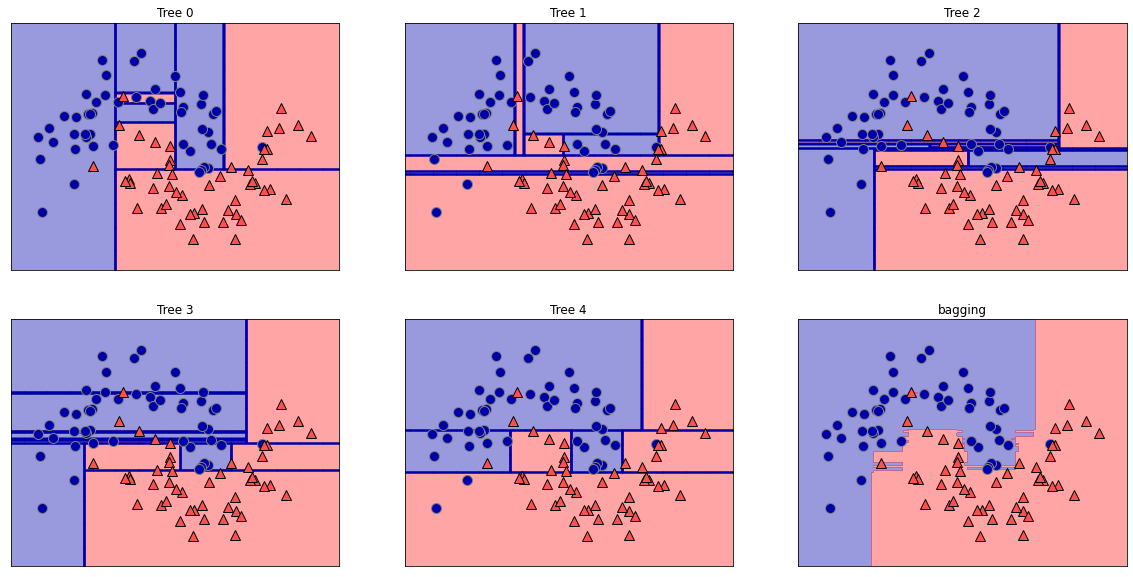

In [103]:
fig, axes = plt.subplots(2, 3, figsize=(20, 10))
for i, (ax,tree) in enumerate(zip(axes.ravel(), bagging.estimators_)):
    ax.set_title("Tree {}".format(i))
    mglearn.plots.plot_tree_partition(Xm, ym, tree, ax=ax)

mglearn.plots.plot_2d_separator(bagging, Xm, fill=True, ax=axes[-1,-1], alpha=.4)
axes[-1, -1].set_title("bagging")
mglearn.discrete_scatter(Xm[:,0], Xm[:,1], ym)
plt.show()

In [108]:
bagging = BaggingClassifier(DecisionTreeClassifier(), n_estimators=100,
                            oob_score=True, n_jobs=-1, random_state=42)
bagging.fit(Xc_train, yc_train)

print("train set acc : {:.3f}".format(bagging.score(Xc_train, yc_train)))
print("test set acc : {:.3f}".format(bagging.score(Xc_test, yc_test)))
print("oob sample acc : {:.3f}".format(bagging.oob_score_))

train set acc : 1.000
test set acc : 0.944
oob sample acc : 0.953


### 엑스트라 트리

In [109]:
from sklearn.ensemble import ExtraTreesClassifier

xtree = ExtraTreesClassifier(n_estimators=5, n_jobs=-1, random_state=0)
xtree.fit(Xm_train, ym_train)

ExtraTreesClassifier(n_estimators=5, n_jobs=-1, random_state=0)

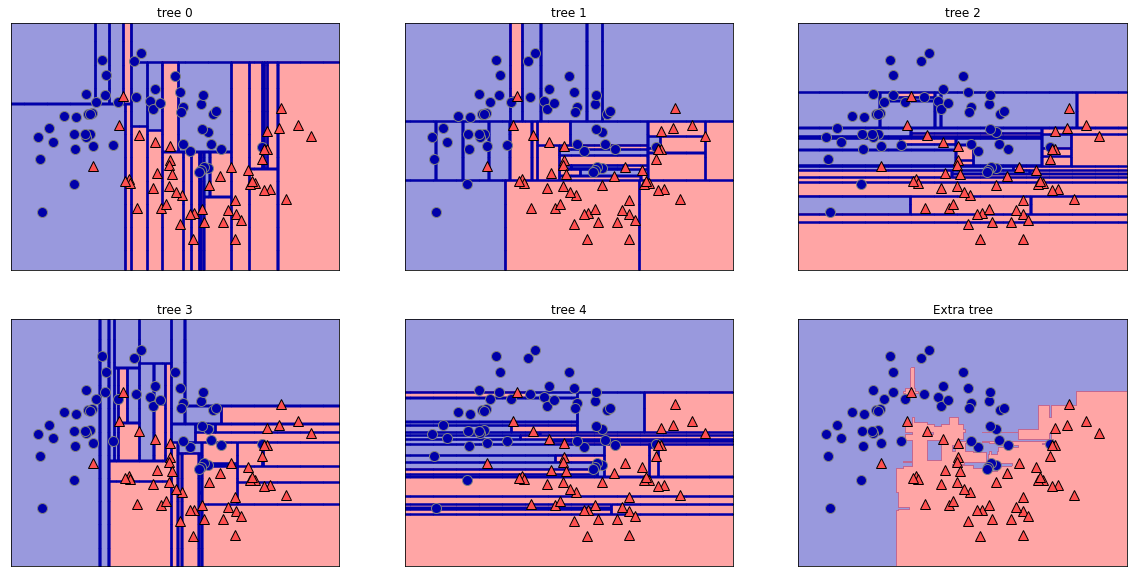

In [111]:
fig, axes = plt.subplots(2, 3, figsize=(20,10))
for i, (ax, tree) in enumerate(zip(axes.ravel(), xtree.estimators_)):
    ax.set_title("tree {}".format(i))
    mglearn.plots.plot_tree_partition(Xm, ym, tree, ax=ax)
    
mglearn.plots.plot_2d_separator(xtree, Xm, fill=True, ax=axes[-1,-1], alpha=.4)
axes[-1,-1].set_title("Extra tree")
mglearn.discrete_scatter(Xm[:,0], Xm[:,1], ym)
plt.show()

In [112]:
xtree = ExtraTreesClassifier(n_estimators=100, n_jobs=-1, random_state=0)
xtree.fit(Xc_train, yc_train)

print("train set acc : {:.3f}".format(xtree.score(Xc_train, yc_train)))
print("test set acc : {:.3f}".format(xtree.score(Xc_test, yc_test)))

train set acc : 1.000
test set acc : 0.944


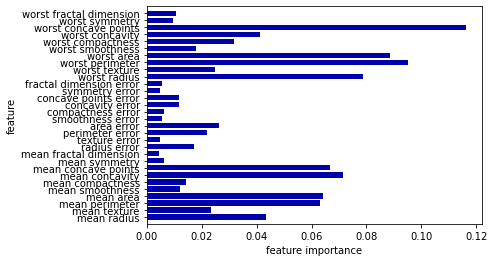

In [113]:
n_features = cancer.data.shape[1]
plt.barh(range(n_features), xtree.feature_importances_, align='center')
plt.yticks(np.arange(n_features), cancer.feature_names)
plt.xlabel("feature importance")
plt.ylabel("feature")
plt.ylim(-1, n_features)
plt.show()

### 에이다부스트

In [114]:
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(n_estimators=5, random_state=42)
ada.fit(Xm_train, ym_train)

AdaBoostClassifier(n_estimators=5, random_state=42)

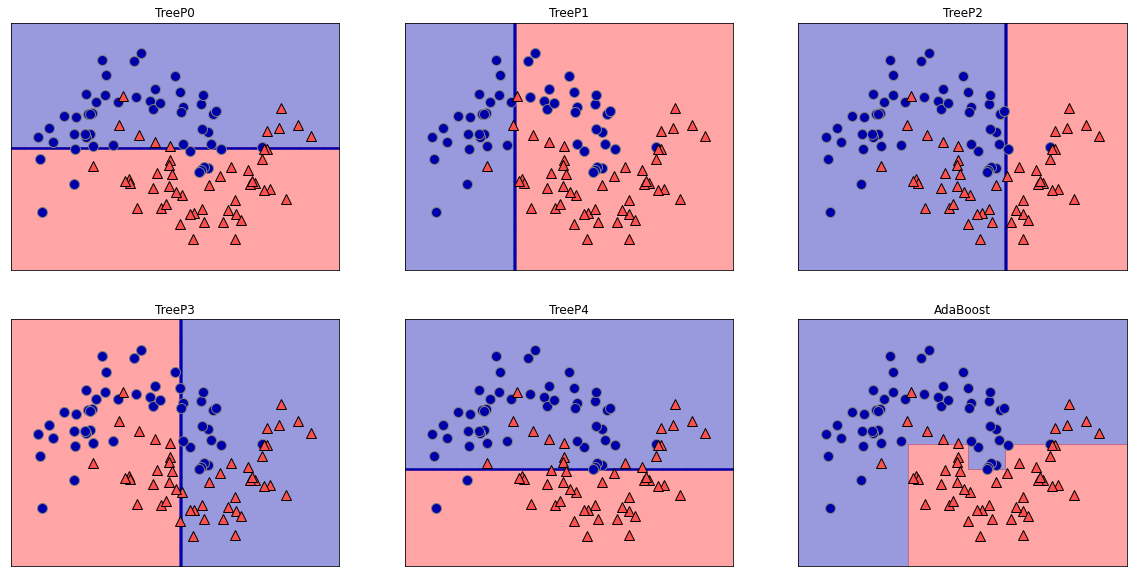

In [116]:
fig, axes = plt.subplots(2,3,figsize=(20,10))
for i, (ax, tree) in enumerate(zip(axes.ravel(),ada.estimators_)):
    ax.set_title("TreeP{}".format(i))
    mglearn.plots.plot_tree_partition(Xm, ym, tree, ax=ax)

mglearn.plots.plot_2d_separator(ada, Xm, fill=True, ax=axes[-1, -1], alpha=.4)
axes[-1, -1].set_title("AdaBoost")
mglearn.discrete_scatter(Xm[:,0],Xm[:,1],ym)
plt.show()

In [117]:
ada = AdaBoostClassifier(n_estimators=100, random_state=42)
ada.fit(Xc_train, yc_train)

print("train set acc : {:.3f}".format(ada.score(Xc_train, yc_train)))
print("test set acc : {:.3f}".format(ada.score(Xc_test, yc_test)))

train set acc : 1.000
test set acc : 0.965


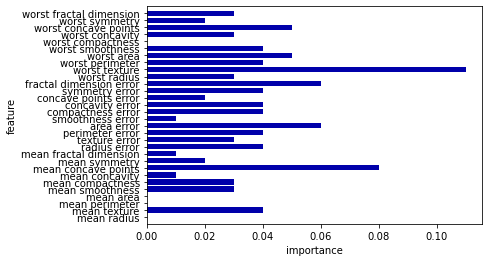

In [118]:
plt.barh(range(n_features), ada.feature_importances_, align='center')
plt.yticks(np.arange(n_features), cancer.feature_names)
plt.xlabel("importance")
plt.ylabel("feature")
plt.ylim(-1, n_features)
plt.show()